# 1. Preparing Data

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

## Contract data

In [256]:
df = pd.read_csv('../data/raw/voc_person_contracts.csv.gz')
df.head()

,vocop_id,full_name,first_name,patronymic,family_name_prefix,family_name,place_of_origin,place_id,disambiguated_person,person_cluster_id,...,changed_ship_at_cape_voyage_id,return_voyage_id,remark,source_id,scan_permalink,full_name_normalized,first_name_normalized,patronymic_normalized,family_name_prefix_normalized,family_name_normalized
0,104944,Adriaen van Renteregem,Adriaen,NaN,van,Renteregem,Wassenaar,141865.0,1.0,415682.0,...,NaN,96993,NaN,3339,NL-HaNA_1.04.02_12674_0192.jpg,Adriaan van Renteregem,Adriaan,NaN,van,Renteregem
1,104945,Adriaen van der Meulen,Adriaen,NaN,van der,Meulen,Cooltiensplate,25576.0,1.0,406243.0,...,NaN,96942,NaN,3339,NL-HaNA_1.04.02_12674_0194.jpg,Adriaan van der Meul,Adriaan,NaN,van der,Meul
2,104946,Arnoldus Coutrel,Arnoldus,NaN,NaN,Coutrel,Antwerpen,6486.0,1.0,1.0,...,NaN,97025,NaN,3339,NL-HaNA_1.04.02_12674_0196.jpg,Arnoldus Koetrel,Arnoldus,NaN,NaN,Koetrel
3,104947,Albert Coolman,Albert,NaN,NaN,Coolman,Amsterdam,5532.0,1.0,77235.0,...,NaN,-1,NaN,3339,NL-HaNA_1.04.02_12674_0198.jpg,Albert Koolman,Albert,NaN,NaN,Koolman
4,104948,Anthonij Bonel,Anthonij,NaN,NaN,Bonel,Amsterdam,5532.0,1.0,65732.0,...,NaN,-1,NaN,3339,NL-HaNA_1.04.02_12674_0200.jpg,Antoni Bonel,Antoni,NaN,NaN,Bonel


In [257]:
print(f'Total number of contracts: {df.shape[0]:,}')

Total number of contracts: 774,200


### Variables

- __vocop_id__: the unique id for each contract <br>
- __disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). <br>
- __person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person <br>
- __date_begin_contract__: start date of contract <br>
- __outward_voyage_id__: unique id of outward voyage.

In [258]:
# select relevant columns

df = df[['vocop_id', 'disambiguated_person', 'person_cluster_id', 'date_begin_contract', 'outward_voyage_id']]

In [259]:
# Remove contracts without a start data
nans = df['date_begin_contract'].isnull().sum()
print(f'Number of contacts with missing data in start date field: {nans}')
df = df.dropna(subset=['date_begin_contract'])


# Only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
print(f'Number of disambiguated records: {len(records):,}')

# Construct year variable
# Pandas does not like old dates, so rather than using Datetime, we extract it from the string
df['year'] = df['date_begin_contract'].str.split('-', expand=True)[0].astype(int)
df = df.sort_values(by='year')
assert df["year"].min() == 1633 and df["year"].max() == 1794

df.to_csv('../data/voyages_clean.csv', index=False)

Number of contacts with missing data in start date field: 257
Number of disambiguated records: 546,973


In [260]:
sailors_df = df[df['outward_voyage_id'] != 0]

In [261]:
contract_counts = sailors_df.groupby('outward_voyage_id')['vocop_id'].count()

# Dutch-Asiatic Shipping (DAS)

In [305]:
das = pd.read_excel('../data/raw/das.xlsx')

das = das[das['voyRGPDeel'] == 166] #only outbound voyages
#das = das[(das['voydepartureY'] >= 1633) & (das['voydepartureY'] <= 1794)] # same time period as contracts

outward_voyage_ids = das['voyId'].values
print(f'number of das records: {das.shape[0]}')

print(f'number of outward voyages: {len(outward_voyage_ids)}')

number of das records: 4787
number of outward voyages: 4787


In [306]:
bins = list(range(1610, 1790, 10)) + [1790]
date_ranges = [(bins[i-1], bins[i]) for i in range(1, len(bins))]
date_ranges.append((1790, 1795))
date_ranges.append((1602, 1700))
date_ranges.append((1700, 1795))
date_ranges.append((1595, 1602))
date_ranges.append((1602, 1610))
print(f'These are the date ranges: {date_ranges}')

These are the date ranges: [(1610, 1620), (1620, 1630), (1630, 1640), (1640, 1650), (1650, 1660), (1660, 1670), (1670, 1680), (1680, 1690), (1690, 1700), (1700, 1710), (1710, 1720), (1720, 1730), (1730, 1740), (1740, 1750), (1750, 1760), (1760, 1770), (1770, 1780), (1780, 1790), (1790, 1795), (1602, 1700), (1700, 1795), (1595, 1602), (1602, 1610)]


In [307]:
das_onboard = pd.read_excel('../data/raw/das.xlsx', sheet_name='onboard')
das_onboard = das_onboard[das_onboard['onbVoyageId'].isin(outward_voyage_ids)] # select outbound vogages in time period

- `onbI`: The number on board at departure. 
- `onbII`: The number dying between the Netherlands and the Cape. 
- `onbIII`: The number who left the ship at the Cape.  
- `onbIV`: The number who came on board at the Cape.
- `onbV`: The number dying on the whole voyage. 
- `onbVI`: The number on board on arrival in Asia.

For our purposes, we only need `onbI` and `onbIV`. These columns contain dirty data, so we need to extract only the integers.

In [308]:
print(das_onboard['onbVoyageId'].nunique())

# not all onboard records have voyage ids that match the information on year of departure and such. 4787 vs 4505

4505


In [309]:
das_onboard = pd.merge(das_onboard, das[['voyId', 'voydepartureY']], left_on='onbVoyageId', right_on='voyId').drop('voyId', axis=1)

In [310]:
# table27_das = list()

# for index, (start, end) in enumerate(date_ranges):
#     d = {}
#     df_slice = das_onboard[das_onboard['voydepartureY'].between(start, end, inclusive="left")]
#     ships = df_slice['onbVoyageId'].nunique()
#     d["period"] = f"{start} - {end}"
#     d['ships'] = ships
#     table27_das.append(d)

In [311]:
# Select rows where onbI is either int or str (removing nans and some weird datetime object)
das_onboard = das_onboard.loc[das_onboard['onbI'].apply(lambda x: isinstance(x, (int, str)))]

das_onboard['onbI'] = das_onboard['onbI'].astype(str).str.extract('(\d+)') #extract digits (400 / 500, +- 400)
das_onboard['onbIV'] = das_onboard['onbIV'].astype(str).str.extract('(\d+)')
das_onboard['onbIV'] = das_onboard['onbIV'].fillna(0) #fill missing with 0 so that we can more easily add them together

In [312]:
das_onboard.shape[0]
print(das_onboard['onbVoyageId'].nunique())

4181


In [313]:
das_onboard['onbCategory'].value_counts()

Seafarers     2912
Soldiers      2631
Passengers    1703
Craftsmen     1308
Total         1268
Name: onbCategory, dtype: int64

In [314]:
# das_onboard = pd.merge(das_onboard, das[['voyId', 'voydepartureY']], left_on='onbVoyageId', right_on='voyId').drop('voyId', axis=1)

The contracts include seafarers, soldiers and craftsmen. We need to remove the passengers

In [315]:
das_onboard

,onbId,onbVoyageId,onbCategory,onbI,onbII,onbIII,onbIV,onbV,onbVI,voydepartureY
0,604755,91055,Total,59,NaN,NaN,0,NaN,NaN,1595.0
1,604760,91056,Total,20,NaN,NaN,0,NaN,NaN,1595.0
2,604765,91057,Total,85,NaN,NaN,0,NaN,NaN,1595.0
3,604770,91058,Total,85,NaN,NaN,0,NaN,NaN,1595.0
4,604775,91059,Total,75,NaN,NaN,0,NaN,NaN,1598.0
...,...,...,...,...,...,...,...,...,...,...
10576,645576,93086,Seafarers,122,5,2,0,5,104,1707.0
10577,645577,93086,Soldiers,38,NaN,1,0,1,25,1707.0
10578,645580,93091,Total,200,22,NaN,0,NaN,NaN,1707.0
10579,645583,93094,Total,100,NaN,NaN,0,NaN,NaN,1707.0


In [316]:
das_onboard['counts'] = das_onboard['onbI'].astype(int).add(das_onboard['onbIV'].astype(int))

In [320]:
das_onboard[das_onboard['onbVoyageId'] == 91356]

,onbId,onbVoyageId,onbCategory,onbI,onbII,onbIII,onbIV,onbV,onbVI,voydepartureY,counts
187,606340,91356,Seafarers,160,NaN,NaN,0,31,129,1625.0,160
188,606341,91356,Soldiers,69,NaN,NaN,0,32,37,1625.0,69
189,606342,91356,Passengers,17,NaN,NaN,0,4,13,1625.0,17


In [302]:
das_onboard = das_onboard[das_onboard['onbCategory'] != 'Passengers']

In [303]:
das_onboard['counts_without_passengers'] = das_onboard['onbI'].astype(int).add(das_onboard['onbIV'].astype(int))

In [325]:
import math
table27_das = list()

das_onboard = das_onboard[das_onboard['onbVoyageId'] != 93096]
das_onboard = das_onboard[das_onboard['onbVoyageId'] != 93096]

for index, (start, end) in enumerate(date_ranges):
    d = {}
    df_slice = das_onboard[das_onboard['voydepartureY'].between(start, end, inclusive="left")]
    ships = df_slice['onbVoyageId'].nunique()
    voyagers = df_slice['counts'].sum()
    voyagers_without_passengers = df_slice[df_slice['onbCategory'] != 'Passengers']['counts'].sum()
    voyagers = int(math.ceil(voyagers / 100.0)) * 100
    voyagers_without_passengers = int(math.ceil(voyagers_without_passengers / 100.0)) * 100
    d["period"] = f"{start} - {end}"
    d['ships'] = ships
    d['voyages'] = voyagers
    d['voyages_no_pass'] = voyagers_without_passengers
    try:
        average = voyagers / ships
        average_no_pass = voyagers_without_passengers / ships
    except Exception:
        average = np.nan
    d['average'] = np.round(average, 1)
    d['average_no_pass'] = np.round(average_no_pass, 1)
    table27_das.append(d)

In [326]:
table27_das

[{'period': '1610 - 1620',
  'ships': 61,
  'voyages': 9600,
  'voyages_no_pass': 9600,
  'average': 157.4,
  'average_no_pass': 157.4},
 {'period': '1620 - 1630',
  'ships': 96,
  'voyages': 16900,
  'voyages_no_pass': 16700,
  'average': 176.0,
  'average_no_pass': 174.0},
 {'period': '1630 - 1640',
  'ships': 22,
  'voyages': 4300,
  'voyages_no_pass': 4300,
  'average': 195.5,
  'average_no_pass': 195.5},
 {'period': '1640 - 1650',
  'ships': 25,
  'voyages': 5200,
  'voyages_no_pass': 5200,
  'average': 208.0,
  'average_no_pass': 208.0},
 {'period': '1650 - 1660',
  'ships': 97,
  'voyages': 20300,
  'voyages_no_pass': 20200,
  'average': 209.3,
  'average_no_pass': 208.2},
 {'period': '1660 - 1670',
  'ships': 231,
  'voyages': 41400,
  'voyages_no_pass': 40500,
  'average': 179.2,
  'average_no_pass': 175.3},
 {'period': '1670 - 1680',
  'ships': 214,
  'voyages': 41400,
  'voyages_no_pass': 40400,
  'average': 193.5,
  'average_no_pass': 188.8},
 {'period': '1680 - 1690',
  's

In [89]:
das_onboard = das_onboard[['onbVoyageId', 'counts']]

# remove extreme values 
# TODO: I'm not sure what a reasonable low count is. There's quite a few with 25 people on board
das_onboard = das_onboard[das_onboard['onbVoyageId'] != 93096]
das_onboard = das_onboard[das_onboard['onbVoyageId'] != 93096]
das_onboard = das_onboard[das_onboard['counts'] != 0]

In [90]:
das_onboard_counts = das_onboard.groupby('onbVoyageId')['counts'].sum().reset_index()

In [91]:
compare_counts = pd.merge(das_onboard_counts, contract_counts, left_on='onbVoyageId', right_on='outward_voyage_id')

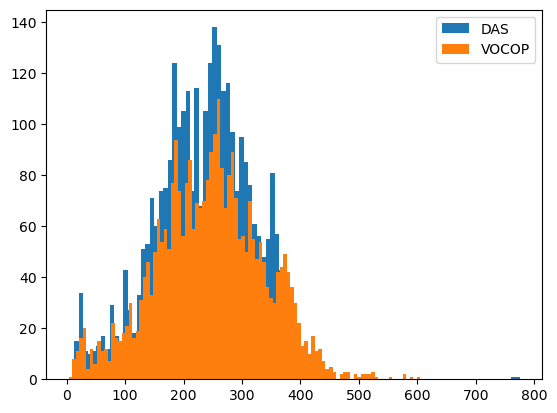

In [92]:
plt.hist(compare_counts['counts'].values, label='DAS', bins=100)
plt.hist(compare_counts['vocop_id'].values, label='VOCOP', bins=100)
plt.legend()

In [93]:
skew(compare_counts['counts'])

-0.1065940027718685

The distribution is slightly skewed, so we might as well take the median

In [94]:
## Impute missing values
impute_missing = pd.DataFrame(outward_voyage_ids, columns=['outward_voyage_id'])

In [95]:
impute_missing = pd.merge(
    impute_missing, das_onboard_counts, left_on ='outward_voyage_id', right_on='onbVoyageId', how='left')

In [96]:
# impute_missing['counts'].fillna(value=impute_missing['counts'].mean(), inplace=True)
# impute_missing['counts'].sum()

In [97]:
impute_missing['counts'].fillna(value=impute_missing['counts'].median(), inplace=True)
impute_missing['counts'].sum()

962398.0

In [98]:
# add voyage ID and year of departure to dataframe
impute_missing = pd.merge(impute_missing, das[['voyId', 'voydepartureY']], left_on='outward_voyage_id', right_on=['voyId'])
impute_missing[['outward_voyage_id', 'counts', 'voydepartureY']].to_csv('../data/seafarer_counts.csv', index=False)